In [1]:
import pandas as pd
import numpy as np
import geopandas
import shapely.geometry as geom
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## BUSTE Baseline

In [2]:
zones_data = geopandas.GeoDataFrame.from_file('/local/tarciso/data/pesquisa-od-ctba/shapefiles/181zonas_metadata.shp')

In [3]:
macrozones_density = zones_data.groupby('cod_macroz') \
                                    .agg({'densidade':'sum'}) \
                                    .reset_index() \
                                    .assign(densidade = lambda x: x.densidade/sum(x.densidade)) \
                                    .rename(index=str, columns={'densidade':'pop_density'})

In [4]:
macrozones_density

,cod_macroz,pop_density
0,1.0,0.192068
1,2.0,0.144332
2,3.0,0.111909
3,4.0,0.061180
4,5.0,0.113174
5,6.0,0.079210
6,7.0,0.102418
7,8.0,0.061365
8,9.0,0.109374
9,10.0,0.024971


In [6]:
sum(macrozones_density['pop_density'])

1.0000000000000002

In [5]:
macrozones_density.to_csv('/local/tarciso/data/od-mat-validation/macrozones_pop_density.csv',index=False)

## Start from origin zone-matched data

### Bus-Station matched Origins (BUSTE result)

#### Reading and Preparing Origin zone-matched data

In [13]:
trips_origins_zones = pd.read_csv('/local/tarciso/data/buste/BUSTE_zones_all.csv',parse_dates=['start_time'])

/home/tarciso/anaconda2/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
len(trips_origins_zones)

5493679

In [19]:
trips_origins_zones.dtypes

card_num                  int64
route                    object
start_time       datetime64[ns]
from_stop_id              int64
from_stop_lat           float64
from_stop_lon           float64
cod_zona_o                int64
cod_macroz_o            float64
municipio_o              object
densidade_o               int64
dtype: object

In [20]:
trips_origins_zones.head()

,card_num,route,start_time,from_stop_id,from_stop_lat,from_stop_lon,cod_zona_o,cod_macroz_o,municipio_o,densidade_o
0,840541,463,2017-04-30 05:49:19,31707,-25.478025,-49.203033,494,3.0,CURITIBA,10892
1,3545809,463,2017-04-30 05:57:45,30929,-25.443967,-49.237920,351,1.0,CURITIBA,2838
2,2351881,463,2017-04-30 06:45:52,31532,-25.476831,-49.192415,494,3.0,CURITIBA,10892
3,2114350,463,2017-04-30 06:45:44,31532,-25.476831,-49.192415,494,3.0,CURITIBA,10892
4,1698948,463,2017-04-30 06:45:40,31532,-25.476831,-49.192415,494,3.0,CURITIBA,10892


In [21]:
trips_origins_zones[pd.isnull(trips_origins_zones['cod_zona_o'])]

,card_num,route,start_time,from_stop_id,from_stop_lat,from_stop_lon,cod_zona_o,cod_macroz_o,municipio_o,densidade_o


In [22]:
trips_origins_zones.dtypes

card_num                  int64
route                    object
start_time       datetime64[ns]
from_stop_id              int64
from_stop_lat           float64
from_stop_lon           float64
cod_zona_o                int64
cod_macroz_o            float64
municipio_o              object
densidade_o               int64
dtype: object

### Inferring Aggregated Destination Macrozones based on Origin Population Density 

In [25]:
agg_trips_origin_zones = trips_origins_zones.groupby('cod_macroz_o').card_num.count().reset_index() \
                                            .rename(index=str, columns={'card_num':'macroz_total_boardings'})

In [26]:
agg_trips_origin_zones

,cod_macroz_o,macroz_total_boardings
0,1.0,1409279
1,2.0,391638
2,3.0,433591
3,4.0,528272
4,5.0,742349
5,6.0,400285
6,7.0,337604
7,8.0,670761
8,9.0,257232
9,10.0,288418


In [35]:
macrozones_density = macrozones_density.rename(index=str, columns={'cod_macroz':'cod_macroz_d'})

In [36]:
macrozones_density

,cod_macroz_d,pop_density,key
0,1.0,0.192068,1
1,2.0,0.144332,1
2,3.0,0.111909,1
3,4.0,0.061180,1
4,5.0,0.113174,1
5,6.0,0.079210,1
6,7.0,0.102418,1
7,8.0,0.061365,1
8,9.0,0.109374,1
9,10.0,0.024971,1


In [37]:
agg_trips_origin_zones['key'] = 1
macrozones_density['key'] = 1

In [38]:
agg_trips_od_zones = agg_trips_origin_zones.merge(macrozones_density, how='outer') \
                                        .filter(['cod_macroz_o','cod_macroz_d','macroz_total_boardings','pop_density']) \
                                        .assign(num_trips = lambda x: np.rint(x.macroz_total_boardings*x.pop_density))

In [39]:
agg_trips_od_zones

,cod_macroz_o,cod_macroz_d,macroz_total_boardings,pop_density,num_trips
0,1.0,1.0,1409279,0.192068,270677.0
1,1.0,2.0,1409279,0.144332,203404.0
2,1.0,3.0,1409279,0.111909,157711.0
3,1.0,4.0,1409279,0.061180,86219.0
4,1.0,5.0,1409279,0.113174,159493.0
5,1.0,6.0,1409279,0.079210,111629.0
6,1.0,7.0,1409279,0.102418,144336.0
7,1.0,8.0,1409279,0.061365,86480.0
8,1.0,9.0,1409279,0.109374,154138.0
9,1.0,10.0,1409279,0.024971,35191.0


In [40]:
agg_trips_od_zones.groupby(['cod_macroz_o']).agg({'num_trips':'sum'})

,num_trips
cod_macroz_o,
1.0,1409278.0
2.0,391639.0
3.0,433591.0
4.0,528271.0
5.0,742348.0
6.0,400287.0
7.0,337604.0
8.0,670762.0
9.0,257231.0


In [41]:
buste_baseline = agg_trips_od_zones.filter(['cod_macroz_o','cod_macroz_d','num_trips'])

In [42]:
buste_baseline

,cod_macroz_o,cod_macroz_d,num_trips
0,1.0,1.0,270677.0
1,1.0,2.0,203404.0
2,1.0,3.0,157711.0
3,1.0,4.0,86219.0
4,1.0,5.0,159493.0
5,1.0,6.0,111629.0
6,1.0,7.0,144336.0
7,1.0,8.0,86480.0
8,1.0,9.0,154138.0
9,1.0,10.0,35191.0


## Generating Estimated Trips OD Matrix for Macrozones

In [43]:
buste_baseline_macrozones_freqs = buste_baseline.pivot(index='cod_macroz_o',columns='cod_macroz_d',values='num_trips')

In [44]:
buste_baseline_macrozones_freqs

cod_macroz_d,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
cod_macroz_o,,,,,,,,,,
1.0,270677.0,203404.0,157711.0,86219.0,159493.0,111629.0,144336.0,86480.0,154138.0,35191.0
2.0,75221.0,56526.0,43828.0,23960.0,44323.0,31022.0,40111.0,24033.0,42835.0,9780.0
3.0,83279.0,62581.0,48523.0,26527.0,49071.0,34345.0,44408.0,26607.0,47423.0,10827.0
4.0,101464.0,76246.0,59118.0,32319.0,59787.0,41844.0,54105.0,32417.0,57779.0,13192.0
5.0,142581.0,107145.0,83076.0,45417.0,84014.0,58801.0,76030.0,45554.0,81193.0,18537.0
6.0,76882.0,57774.0,44796.0,24489.0,45302.0,31707.0,40997.0,24563.0,43781.0,9996.0
7.0,64843.0,48727.0,37781.0,20654.0,38208.0,26742.0,34577.0,20717.0,36925.0,8430.0
8.0,128832.0,96812.0,75064.0,41037.0,75913.0,53131.0,68698.0,41161.0,73364.0,16750.0
9.0,49406.0,37127.0,28787.0,15737.0,29112.0,20375.0,26345.0,15785.0,28134.0,6423.0


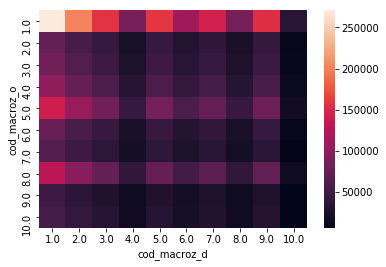

In [47]:
sns.heatmap(buste_baseline_macrozones_freqs)

In [48]:
buste_baseline_macrozones_norm_freqs = buste_baseline_macrozones_freqs/buste_baseline_macrozones_freqs.values.sum()

In [49]:
buste_baseline_macrozones_norm_freqs

cod_macroz_d,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
cod_macroz_o,,,,,,,,,,
1.0,0.049580,0.037257,0.028888,0.015793,0.029214,0.020447,0.026438,0.015840,0.028233,0.006446
2.0,0.013778,0.010354,0.008028,0.004389,0.008119,0.005682,0.007347,0.004402,0.007846,0.001791
3.0,0.015254,0.011463,0.008888,0.004859,0.008988,0.006291,0.008134,0.004874,0.008686,0.001983
4.0,0.018585,0.013966,0.010829,0.005920,0.010951,0.007665,0.009910,0.005938,0.010583,0.002416
5.0,0.026116,0.019626,0.015217,0.008319,0.015389,0.010771,0.013926,0.008344,0.014872,0.003395
6.0,0.014082,0.010582,0.008205,0.004486,0.008298,0.005808,0.007509,0.004499,0.008019,0.001831
7.0,0.011877,0.008925,0.006920,0.003783,0.006999,0.004898,0.006333,0.003795,0.006764,0.001544
8.0,0.023598,0.017733,0.013749,0.007517,0.013905,0.009732,0.012583,0.007539,0.013438,0.003068
9.0,0.009050,0.006801,0.005273,0.002883,0.005332,0.003732,0.004826,0.002891,0.005153,0.001176


In [50]:
buste_baseline_macrozones_norm_freqs.to_csv('/local/tarciso/data/od-mat-validation/buste_baseline_macrozones_norm_freqs.csv')

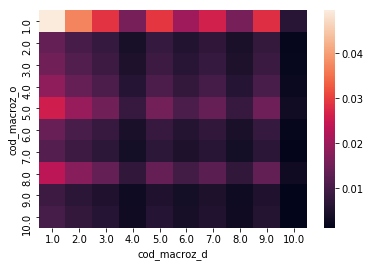

In [51]:
sns.heatmap(buste_baseline_macrozones_norm_freqs)